# weatheri 일자별 데이터 크롤링

In [42]:
!pip install webdriver-manager

  Using cached webdriver_manager-3.8.6-py2.py3-none-any.whl (27 kB)
  Using cached python_dotenv-1.0.0-py3-none-any.whl (19 kB)
                                              0.0/77.1 kB ? eta -:--:--
     ---------------------------------------- 77.1/77.1 kB 4.2 MB/s eta 0:00:00


In [3]:
# %%writefile ./crawler/weather_crawler.py
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import re
import asyncio
import aiohttp
import selenium 
from selenium import webdriver
from selenium.webdriver.edge.service import Service
import time
import re
import sys

# url 설정
url = r'https://www.weatheri.co.kr/bygone/bygone01.php'
# user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
# headers = { 'User-Agent' : user_agent }
# 드라이버 경로 설정
driver_path = r'./browserdriver/msedgedriver112_64.exe'
# column name 설정
col_name = ['날짜', '평균기온', '최고기온', '최저기온', '강수량(mm)', '신적설(cm)', '평균풍속(m/s)', '평균습도(%)', '운량(1/10)', '일조시간(hr)', '날씨']


s_date = (1967, 1, 1)
e_date = (2023, 4, 30)

# 출력을 새로고침 해주며 현재날짜 프린트
def print_current(s):
    sys.stdout.write('\r')
    sys.stdout.write('현재 처리중 : ' + s)
    sys.stdout.flush()

# 문자열로 된 날짜를 Timestamp로 변환
def get_time_in_str(date_str):
    y_p = re.compile(r'(\d{4})년')
    m_p = re.compile(r'(\d{1,2})월')
    d_p = re.compile(r'(\d{1,2})일')
    y = y_p.search(date_str).group(1)
    m = m_p.search(date_str).group(1)
    d = d_p.search(date_str).group(1)
    return pd.Timestamp(int(y), int(m), int(d))

# 문자열로 된 숫자를 float로 변환
def get_float_in_str(s):
    if s == '-':
        return 0.0
    else:
        return float(s)

# 웹드라이버 객체를 생성하는 함수
def get_browser(headless=True):
    service = Service(driver_path)
    # 웹드라이버 옵션 설정
    options = webdriver.EdgeOptions()   # EdgeOptions객체 생성
    if headless:
        options.add_argument('headless')    # headless 모드 설정 -> 화면이 안나옴
        options.add_argument("disable-gpu") # GPU 사용 안함

    # webdriver  객체를 만들 때 옵션을 설정
    browser = webdriver.Edge(service=service, options=options)
    
    return browser

# 날씨 데이터를 가져오는 함수
def get_weather_data(browser, s_date, e_date):
    # 날씨 데이터를 담을 딕셔너리 생성
    print_current('날씨 데이터를 담을 딕셔너리 생성')
    weather_data = {}
    for name in col_name:
        weather_data[name] = []
    # 웹드라이버 실행
    print_current('웹드라이버 실행')
    browser.get(url)
    # css selectors
    print_current('css selectors 설정')
    view_bnt_css = 'body > table > tbody > tr > td > form > table > tbody > tr > td > img'
    search_bnt_scc = r'body > table:nth-child(4) > tbody > tr:nth-child(3) > td:nth-child(3) > table > tbody > tr:nth-child(2) > td > img'
    tbody_css = r'body > table > tbody > tr > td > form > table:nth-child(2) > tbody > tr > td > table > tbody'
    row_css = r'tr:nth-child({i})'
    # 행 내의 열별 셀렉터
    col_css = {}
    for i, name in enumerate(col_name):
        if i == 0:
            col_css[name] = r'td:nth-child({i}) > b'.format(i=i+1)
        else:
            col_css[name] = r'td:nth-child({i}) > font'.format(i=i+1)
    # 행별 데이터 처리 함수
    print_current('행별 데이터 처리 함수 설정')
    col_func = {}
    for name in col_name:
        if name == '날짜':
            col_func[name] = get_time_in_str
        elif name == '날씨':
            col_func[name] = lambda x: x
        else:
            col_func[name] = get_float_in_str
    
    # 날짜 셀렉터 찾기
    print_current('날짜 셀렉터 처리중')
    s_year_select = browser.find_element(by='name', value='s_year')
    s_month_select = browser.find_element(by='name', value='s_month')
    s_day_select = browser.find_element(by='name', value='s_day')

    e_year_select = browser.find_element(by='name', value='e_year')
    e_month_select = browser.find_element(by='name', value='e_month')
    e_day_select = browser.find_element(by='name', value='e_day')
    
    # 날짜 셀렉터에 시작 날짜 입력하기
    s_year_select.send_keys(s_date[0])
    if s_date[1] != 1:
        s_month_select.send_keys(s_date[1])
    if s_date[2] != 1:
        s_day_select.send_keys(s_date[2])
    # 날짜 셀렉터에 종료 날짜 입력하기
    e_year_select.send_keys(e_date[0])
    e_month_select.send_keys(e_date[1])
    e_day_select.send_keys(e_date[2])
    
    # 날짜선택 후 검색버튼 클릭
    print_current('검색')
    search_bnt = browser.find_element(by='css selector', value=search_bnt_scc)
    search_bnt.click()
    
    # iframe 객체를 찾아서 iframe으로 전환
    print_current('iframe 전환')
    kako_iframe = browser.find_element(by='name', value='kako')
    browser.switch_to.frame(kako_iframe)
    
    # 월별 셀렉터 찾기
    print_current('월별 셀렉터 설정')
    date_select = browser.find_element(by='name', value='start')
    # 월별 셀렉터에서 월별 날짜들 찾기
    starts = date_select.find_elements(by='tag name', value='option')
    # 월별 날짜들의 텍스트만 가져오기
    print_current('월별 텍스트 추출')
    starts = [start.text for start in starts]
    
    for start in starts:
        print_current(start)
        # 월별 셀렉터 찾기
        start_select = browser.find_element(by='name', value='start')
        # 월별 셀렉터에서 월 입력
        start_select.send_keys(start)
        # 월별 검색버튼 찾기
        view_bnt = browser.find_element(by='css selector', value=view_bnt_css)
        # 월별 검색버튼 클릭
        view_bnt.click()
        
        time.sleep(0.05)
        # 표 가져오기
        tbody = browser.find_element(by='css selector', value=tbody_css)
        tobdy_html = tbody.get_attribute('innerHTML')
        tbody_bs = bs(tobdy_html, 'lxml')
        # 각 행별로 데이터 가져오기
        for i in range(1, 32):
            # 행 가져오기
            row = tbody_bs.select_one(row_css.format(i=i+1))
            # 행이 없으면 다음 월로 넘어가기
            if row is None:
                break
            print_current(start + f' {i}일')
            # 각 열별로 데이터 가져오기
            for name in col_name:
                print_current(start + f' {i}일' + f' {name} 처리중')
                # 열 가져오기
                col = row.select_one(col_css[name])
                # 열의 데이터 가져오기 (열별로 함수 적용)
                col_data = col_func[name](col.text)
                # 열의 데이터를 딕셔너리에 추가
                weather_data[name].append(col_data)
    
    # 웹드라이버 종료
    browser.quit()
    start_ = pd.Timestamp(s_date[0], s_date[1], s_date[2])
    end_ = pd.Timestamp(e_date[0], e_date[1], e_date[2])
    date_2023_02 = pd.Timestamp(2023, 2, 1)
    if start_ < date_2023_02 and end_ > date_2023_02:
        # 2월 데이터 크롤링
        browser2 = get_browser()
        weather_data2 = get_2_data(browser2)
        # 전체 데이터에 2월 데이터 추가
        for name in col_name:
            weather_data[name] += weather_data2[name]
    
    print_current('데이터 크롤링 완료')
    # 완성된 날씨 데이터 반환
    return weather_data

# 날씨 데이터를 데이터프레임으로 변환하는 함수
def get_weather_df(weather_data):
    print_current('데이터프레임 생성')
    # 데이터프레임 생성
    weather_df = pd.DataFrame(weather_data)
    print_current('데이터프레임 생성 완료')
    # 날짜를 인덱스로 설정
    weather_df.set_index('날짜', inplace=True)
    # 날짜를 기준으로 정렬
    weather_df.sort_index(inplace=True)
    # 데이터프레임 반환
    return weather_df

# 날씨 데이터를 저장하는 함수
def save_weather_df(df, s_date, e_date, file_path='./data/'):
    print_current('데이터 저장중')
    # ./data/start_end_weather.csv 파일로 저장
    start_date = r'{y}{m:02d}{d:02d}'.format(y=s_date[0], m=s_date[1], d=s_date[2])
    end_date = r'{y}{m:02d}{d:02d}'.format(y=e_date[0], m=e_date[1], d=e_date[2])
    file_name = file_path + r'{start}_{end}_weather.csv'.format(start=start_date, end=end_date)
    df.to_csv(file_name, index=True)
    print_current('데이터 저장 완료')
    
# 날씨 데이터를 가져오는 함수
def load_weather_df(filename = '19670101_20230430_weather.csv', file_path='./data/'):
    print_current('데이터 불러오기')
    # ./data/start_end_weather.csv 파일 불러오기
    file_name = file_path + filename
    df = pd.read_csv(file_name, na_values=np.nan)
    print_current('데이터 불러오기 완료')
    # 날짜를 timestamp로 변환
    df['날짜'] = pd.to_datetime(df['날짜'])
    # 날짜를 인덱스로 설정
    df.set_index('날짜', inplace=True)
    return df

# 2월 데이터를 가져오는 함수
def get_2_data(browser):
    # 시작 날짜, 종료 날짜 설정
    s_date = (2023, 2, 1)
    e_date = (2023, 2, 28)
    # 날씨 데이터를 담을 딕셔너리 생성
    print_current('날씨 데이터를 담을 딕셔너리 생성')
    weather_data = {}
    for name in col_name:
        weather_data[name] = []
    # 웹드라이버 실행
    print_current('웹드라이버 실행')
    browser.get(url)
    # css selectors
    print_current('css selectors 설정')
    view_bnt_css = 'body > table > tbody > tr > td > form > table > tbody > tr > td > img'
    search_bnt_scc = r'body > table:nth-child(4) > tbody > tr:nth-child(3) > td:nth-child(3) > table > tbody > tr:nth-child(2) > td > img'
    tbody_css = r'body > table > tbody > tr > td > form > table:nth-child(2) > tbody > tr > td > table > tbody'
    row_css = r'tr:nth-child({i})'
    # 행 내의 열별 셀렉터
    col_css = {}
    for i, name in enumerate(col_name):
        if i == 0:
            col_css[name] = r'td:nth-child({i}) > b'.format(i=i+1)
        else:
            col_css[name] = r'td:nth-child({i}) > font'.format(i=i+1)
    # 행별 데이터 처리 함수
    print_current('행별 데이터 처리 함수 설정')
    col_func = {}
    for name in col_name:
        if name == '날짜':
            col_func[name] = get_time_in_str
        elif name == '날씨':
            col_func[name] = lambda x: x
        else:
            col_func[name] = get_float_in_str
    
    # 날짜 셀렉터 찾기
    print_current('날짜 셀렉터 처리중')
    s_year_select = browser.find_element(by='name', value='s_year')
    s_month_select = browser.find_element(by='name', value='s_month')
    s_day_select = browser.find_element(by='name', value='s_day')

    e_year_select = browser.find_element(by='name', value='e_year')
    e_month_select = browser.find_element(by='name', value='e_month')
    e_day_select = browser.find_element(by='name', value='e_day')
    
    # 날짜 셀렉터에 시작 날짜 입력하기
    s_year_select.send_keys(s_date[0])
    if s_date[1] != 1:
        s_month_select.send_keys(s_date[1])
    if s_date[2] != 1:
        s_day_select.send_keys(s_date[2])
    # 날짜 셀렉터에 종료 날짜 입력하기
    e_year_select.send_keys(e_date[0])
    e_month_select.send_keys(e_date[1])
    e_day_select.send_keys(e_date[2])
    time.sleep(.1)
    # 날짜선택 후 검색버튼 클릭
    print_current('검색')
    search_bnt = browser.find_element(by='css selector', value=search_bnt_scc)
    search_bnt.click()
    time.sleep(10)
    # iframe 객체를 찾아서 iframe으로 전환
    print_current('iframe 전환')
    kako_iframe = browser.find_element(by='name', value='kako')
    browser.switch_to.frame(kako_iframe)
    
    start = '2023년 2월'
    
    print_current(start)
    
    time.sleep(0.05)
    # 표 가져오기
    tbody = browser.find_element(by='css selector', value=tbody_css)
    tobdy_html = tbody.get_attribute('innerHTML')
    tbody_bs = bs(tobdy_html, 'lxml')
    # 각 행별로 데이터 가져오기
    for i in range(1, 32):
        # 행 가져오기
        row = tbody_bs.select_one(row_css.format(i=i+1))
        # 행이 없으면 다음 월로 넘어가기
        if row is None:
            break
        print_current(start + f' {i}일')
        # 각 열별로 데이터 가져오기
        for name in col_name:
            print_current(start + f' {i}일' + f' {name} 처리중')
            # 열 가져오기
            col = row.select_one(col_css[name])
            # 열의 데이터 가져오기 (열별로 함수 적용)
            col_data = col_func[name](col.text)
            # 열의 데이터를 딕셔너리에 추가
            weather_data[name].append(col_data)
    
    # 웹드라이버 종료
    browser.quit()
    
    print_current('데이터 크롤링 완료')
    # 완성된 날씨 데이터 반환
    return weather_data

Overwriting ./crawler/weather_crawler.py


In [1]:
from crawler import weather_crawler as wc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 날씨 데이터 크롤링 (오래걸림)
# s_date = (1967, 1, 1)
# e_date = (2023, 5, 17)
s_date = (2022, 1, 1)
e_date = (2022, 12, 31)

browser = wc.get_browser()
weather_data = wc.get_weather_data(browser, s_date, e_date)
weather_df = wc.get_weather_df(weather_data)
wc.save_weather_df(weather_df, s_date, e_date)

현재 처리중 : 데이터 저장 완료 완료일 날씨 처리중r) 처리중중

In [3]:
weather_df.head()

,평균기온,최고기온,최저기온,강수량(mm),신적설(cm),평균풍속(m/s),운량(1/10),일조시간(hr),날씨
날짜,,,,,,,,,
1967-01-01,-2.5,1.5,-7.4,1.5,4.8,3.6,65.0,6.0,5.6
1967-01-02,-8.3,-5.0,-11.1,0.0,0.0,3.9,53.0,0.0,8.4
1967-01-03,-10.3,-6.1,-13.3,0.0,0.0,3.0,48.0,0.0,7.9
1967-01-04,-8.7,-4.2,-12.4,0.0,0.0,2.3,52.0,1.0,4.1
1967-01-05,-5.6,0.8,-11.4,0.0,0.0,1.8,69.0,2.0,7.3


In [3]:
s_date = (1967, 1, 1)
e_date = (2023, 5, 17)
file_name = r'{y}{m:02d}{d:02d}_{y2}{m2:02d}{d2:02d}_weather.csv'.format(y=s_date[0], m=s_date[1], d=s_date[2], y2=e_date[0], m2=e_date[1], d2=e_date[2])
weather_df = wc.load_weather_df(file_name)

현재 처리중 : 데이터 불러오기 완료

In [4]:
weather_df

,평균기온,최고기온,최저기온,강수량(mm),신적설(cm),평균풍속(m/s),평균습도(%),운량(1/10),일조시간(hr)
날짜,,,,,,,,,
1967-01-01,-2.5,1.5,-7.4,1.5,4.8,3.6,65.0,6.0,5.6
1967-01-02,-8.3,-5.0,-11.1,0.0,0.0,3.9,53.0,0.0,8.4
1967-01-03,-10.3,-6.1,-13.3,0.0,0.0,3.0,48.0,0.0,7.9
1967-01-04,-8.7,-4.2,-12.4,0.0,0.0,2.3,52.0,1.0,4.1
1967-01-05,-5.6,0.8,-11.4,0.0,0.0,1.8,69.0,2.0,7.3
...,...,...,...,...,...,...,...,...,...
2023-05-13,17.8,23.9,12.6,0.0,0.0,1.9,62.0,3.6,8.8
2023-05-14,18.0,23.8,12.9,0.0,0.0,2.0,57.0,1.6,9.6
2023-05-15,20.6,27.9,12.8,0.0,0.0,2.3,55.0,2.0,11.6


In [42]:
# 전체 df에 2월 df 병합
weather_df = pd.concat([weather_df, weather_df2])

In [43]:
wc.save_weather_df(weather_df, s_date, e_date)

현재 처리중 : 데이터 저장 완료

In [11]:
file_name = r'{y}{m:02d}{d:02d}_{y2}{m2:02d}{d2:02d}_weather.csv'.format(y=s_date[0], m=s_date[1], d=s_date[2], y2=e_date[0], m2=e_date[1], d2=e_date[2])
weather_df = wc.load_weather_df(file_name)

현재 처리중 : 데이터 불러오기

FileNotFoundError: [Errno 2] No such file or directory: './data/19670101_20230430_weather.csv'

In [23]:
weather_df.head()

,평균기온,최고기온,최저기온,강수량(mm),신적설(cm),평균풍속(m/s),운량(1/10),일조시간(hr),날씨
날짜,,,,,,,,,
1967-01-01,-2.5,1.5,-7.4,1.5,4.8,3.6,65.0,6.0,5.6
1967-01-02,-8.3,-5.0,-11.1,0.0,0.0,3.9,53.0,0.0,8.4
1967-01-03,-10.3,-6.1,-13.3,0.0,0.0,3.0,48.0,0.0,7.9
1967-01-04,-8.7,-4.2,-12.4,0.0,0.0,2.3,52.0,1.0,4.1
1967-01-05,-5.6,0.8,-11.4,0.0,0.0,1.8,69.0,2.0,7.3


In [4]:
weather_df.tail()

,평균기온,최고기온,최저기온,강수량(mm),신적설(cm),평균풍속(m/s),운량(1/10),일조시간(hr),날씨
날짜,,,,,,,,,
2023-05-13,17.8,23.9,12.6,0.0,0.0,1.9,62.0,3.6,8.8
2023-05-14,18.0,23.8,12.9,0.0,0.0,2.0,57.0,1.6,9.6
2023-05-15,20.6,27.9,12.8,0.0,0.0,2.3,55.0,2.0,11.6
2023-05-16,24.0,31.2,17.2,0.0,0.0,2.5,52.0,2.1,12.1
2023-05-17,23.5,28.7,18.6,0.0,0.0,3.4,64.0,4.6,11.4


In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20113 entries, 1967-01-01 to 2023-05-17
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   평균기온       20113 non-null  float64
 1   최고기온       20113 non-null  float64
 2   최저기온       20113 non-null  float64
 3   강수량(mm)    20113 non-null  float64
 4   신적설(cm)    20113 non-null  float64
 5   평균풍속(m/s)  20113 non-null  float64
 6   운량(1/10)   20113 non-null  float64
 7   일조시간(hr)   20113 non-null  float64
 8   날씨         20113 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [6]:
# 날짜를 인덱스로 설정
weather_df = weather_df.set_index('날짜')

KeyError: "None of ['날짜'] are in the columns"

In [ ]:
weather_df.drop('날씨', axis=1, inplace=True)

<Axes: xlabel='날짜'>

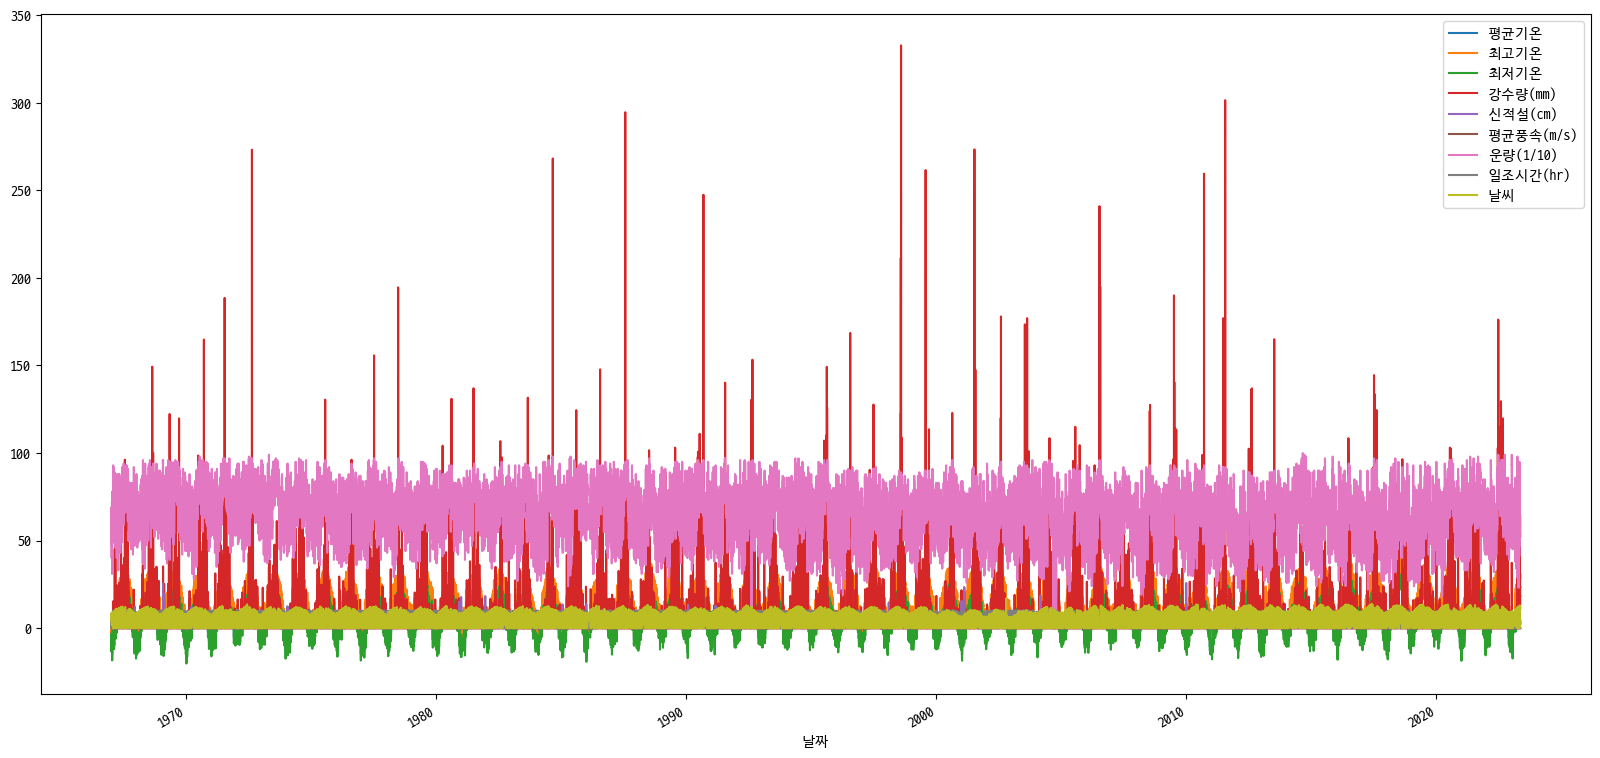

In [7]:
weather_df.plot(figsize=(20, 10))

([<matplotlib.axis.XTick at 0x1b53deab580>,
 [Text(19476, 0, '29'),
  Text(19477, 0, ''),
  Text(19478, 0, '01\nMay\n2023'),
  Text(19479, 0, '02')])

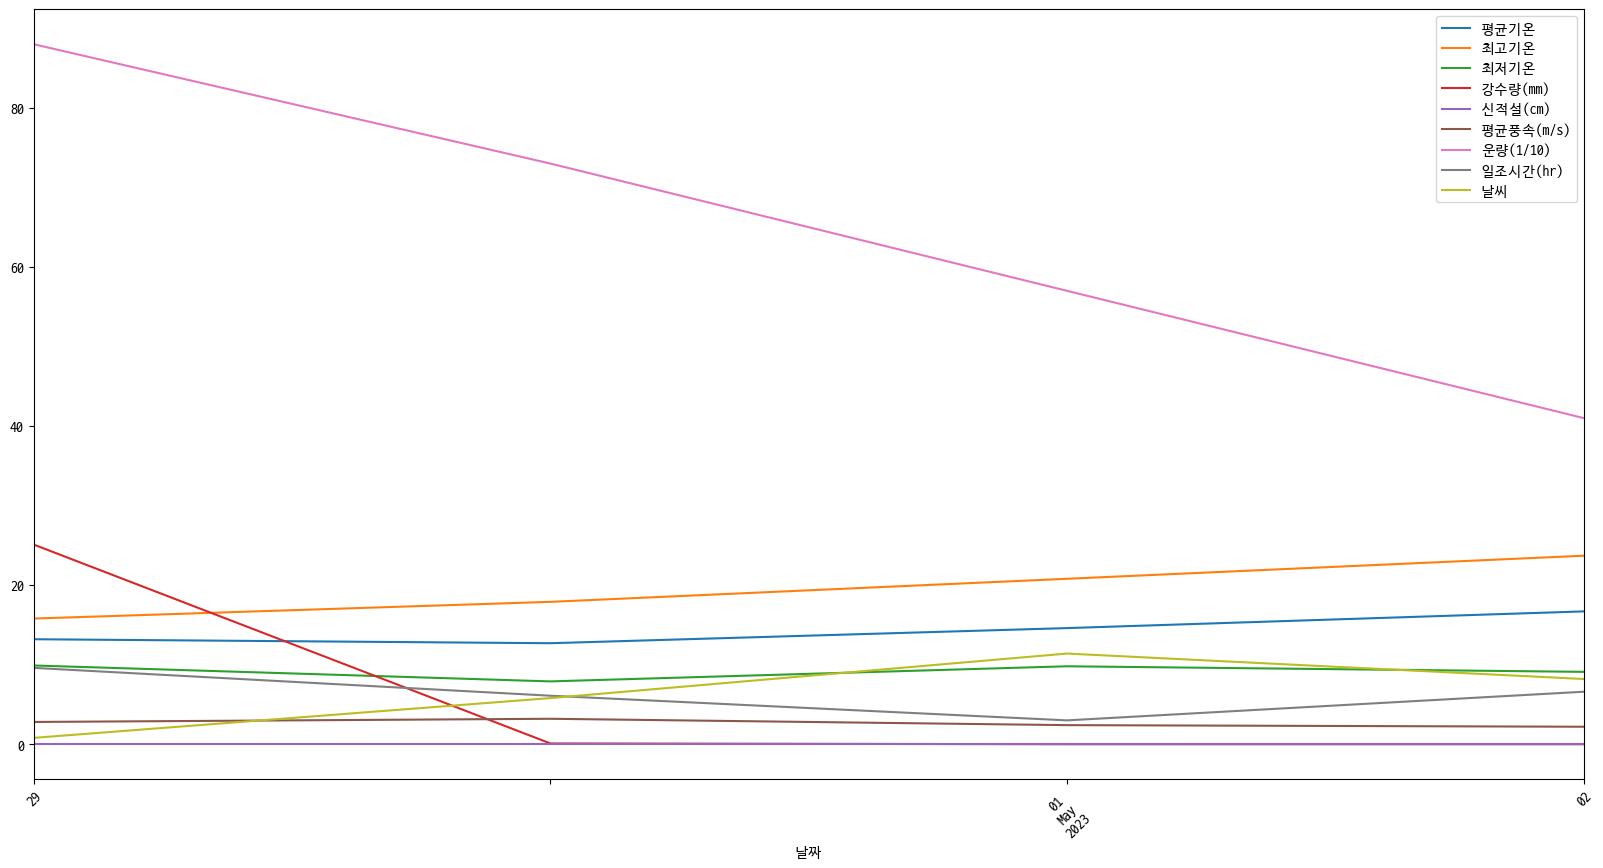

In [12]:

start_date = pd.Timestamp(2023, 4, 29)
end_date = pd.Timestamp(2023, 5, 2)
xticks = pd.date_range(start_date, end_date)
weather_df.loc[start_date:end_date].plot(figsize=(20, 10))
plt.xticks(xticks, rotation=45)

In [123]:
# 연도-월별 각 컬럼의 평균
yymmmean_df = weather_df.groupby([weather_df.index.year, weather_df.index.month]).mean()
yymmmean_df

평균기온       최고기온       최저기온   강수량(mm)   신적설(cm)  평균풍속(m/s)   
날짜   날짜                                                                   
1967 1   -4.363333   0.420000  -8.406667  0.823333  0.270000   2.853333  \
     2   -2.450000   1.503571  -5.810714  1.950000  0.325000   2.778571   
     3    4.680000   9.653333   0.630000  2.940000  0.000000   2.886667   
     4   11.826667  17.303333   7.290000  3.110000  0.000000   3.036667   
     5   19.246667  25.666667  14.156667  1.986667  0.000000   2.343333   
...            ...        ...        ...       ...       ...        ...   
2022 12  -2.873333   1.643333  -6.620000  0.453333  0.356667   2.320000   
2023 1   -1.656667   3.043333  -5.766667  1.596667  0.290000   2.403333   
     3    9.606667  15.930000   4.070000  0.350000  0.000000   2.350000   
     4   13.800000  18.953333   8.806667  3.230000  0.000000   2.533333   
     5   18.235294  24.205882  12.576471  4.570588  0.000000   2.435294   

          운량(1/10)  일조시간(hr)  
날짜   날짜                       
1967 1   61.833333  3.073333  
     2   64.500000  4.225000  
     3   65.733333  5.460000  
     4   67.000000  6.560000  
     5   63.200000  4.870000  
...            ...       ...  
2022 12  58.800000  3.266667  
2023 1   63.133333  3.570000  
     3   51.533333  3.463333  
     4   59.966667  5.320000  
     5   58.764706  4.464706  

[674 rows x 8 columns]

<Axes: xlabel='날짜,날짜'>

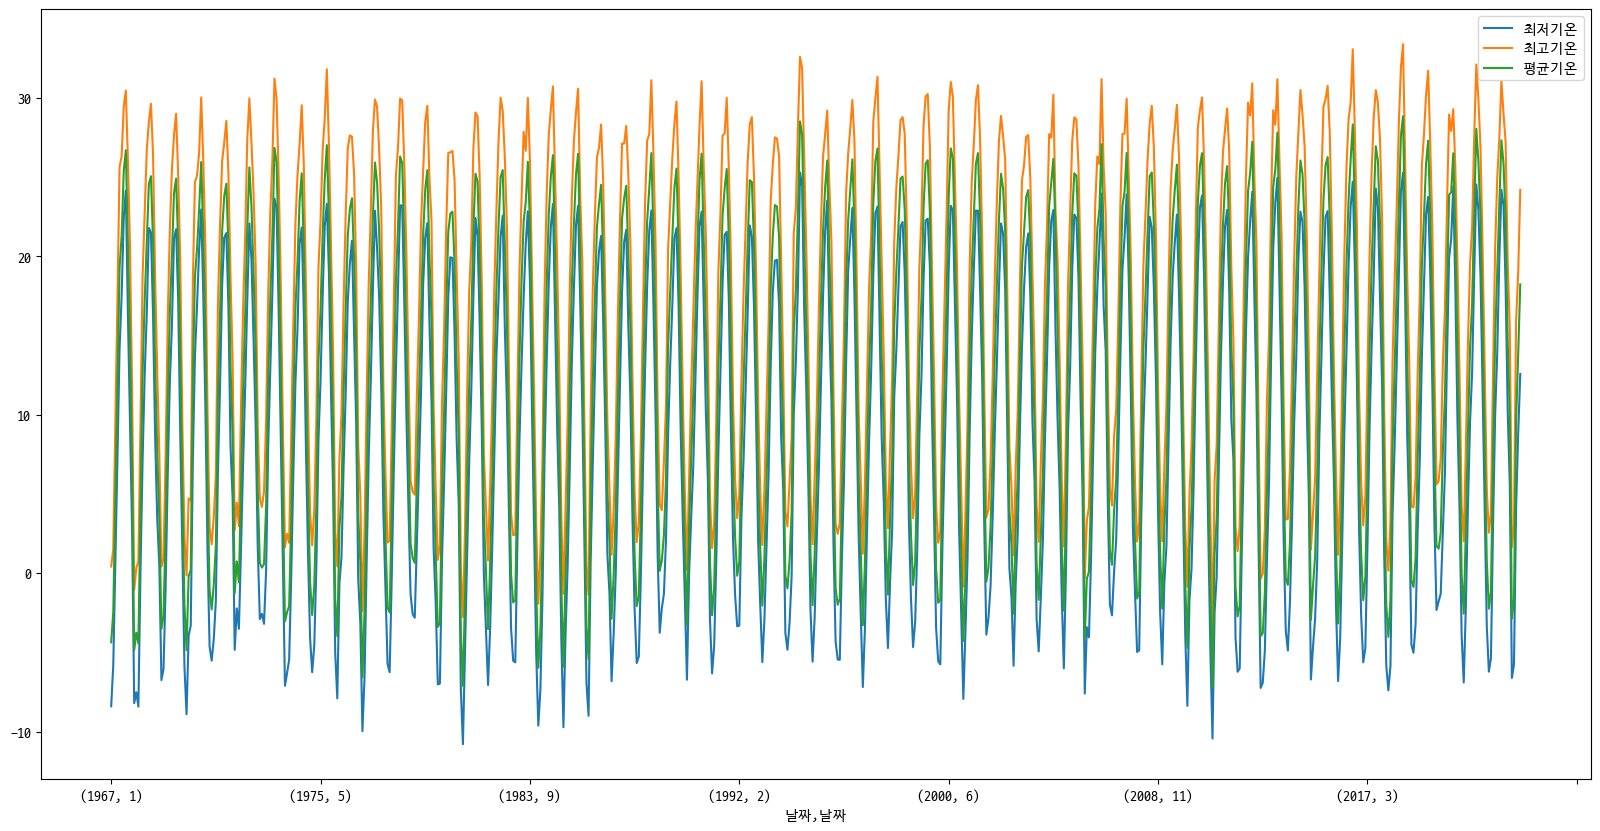

In [125]:
yymmmean_df[['최저기온', '최고기온', '평균기온']].plot(figsize=(20, 10))

<Axes: xlabel='날짜,날짜'>

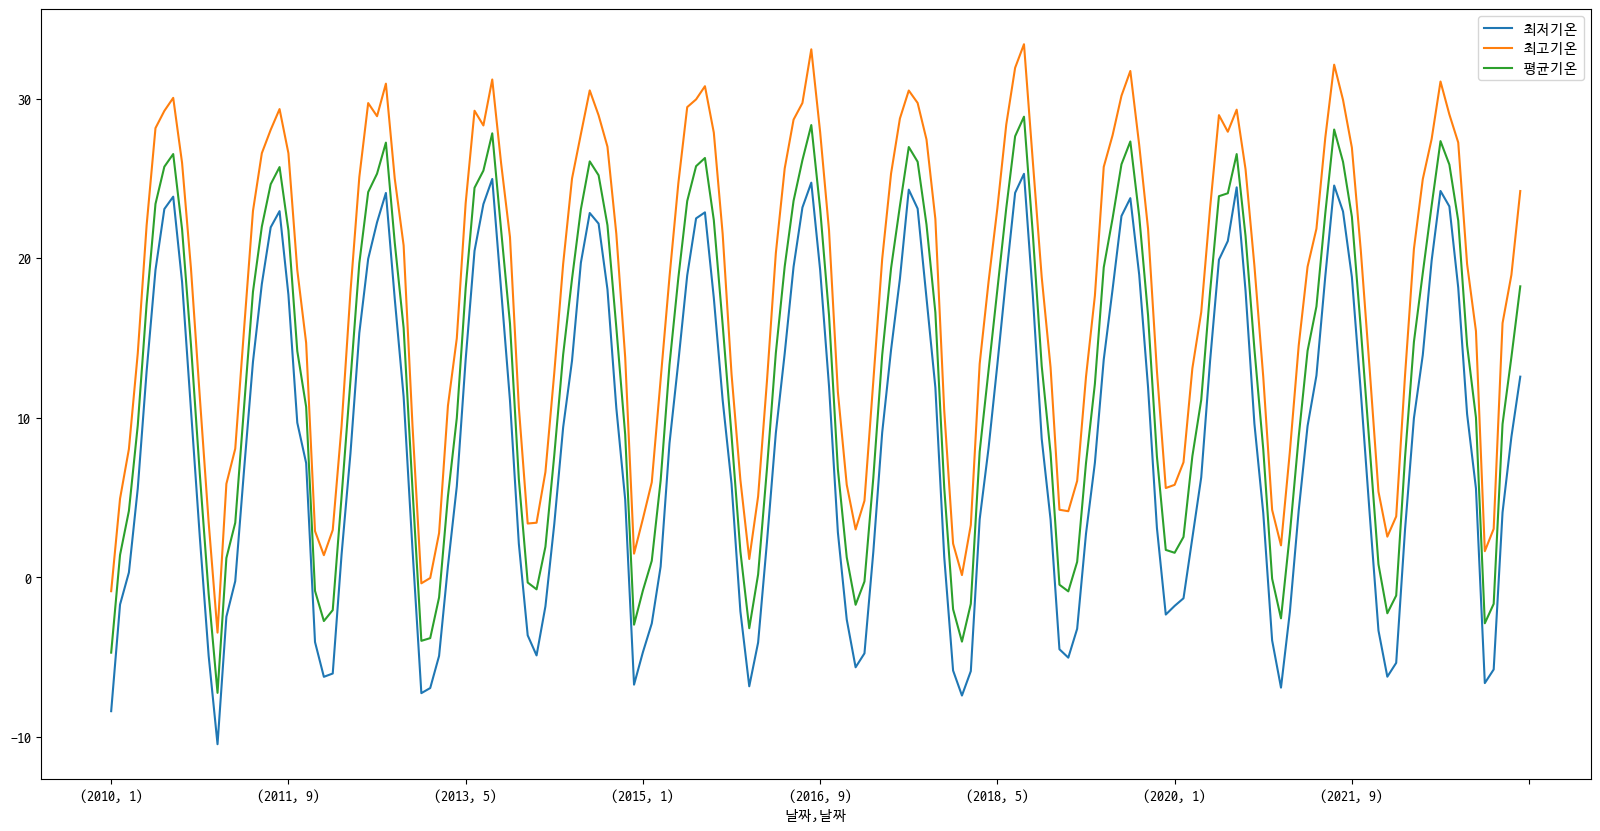

In [184]:
#2010년대 이후의 데이터만 추출
yymmmean_df[['최저기온', '최고기온', '평균기온']].loc[2010:].plot(figsize=(20, 10))

In [133]:
yymean = weather_df.groupby([weather_df.index.year])['평균기온'].mean().drop(2023)
yymean.head()

날짜
1967    11.692458
1968    11.830919
1969    10.919553
1970    11.427933
1971    11.532402
Name: 평균기온, dtype: float64

In [134]:
yymax = weather_df.groupby([weather_df.index.year])['최고기온'].max().drop(2023)
yymin = weather_df.groupby([weather_df.index.year])['최저기온'].min().drop(2023)

In [136]:
yy_mean_max_min = pd.concat([yymean, yymax, yymin], axis=1)
yy_mean_max_min.head()

,평균기온,최고기온,최저기온
날짜,,,
1967,11.692458,35.0,-18.4
1968,11.830919,34.2,-15.1
1969,10.919553,32.9,-15.9
1970,11.427933,35.0,-20.2
1971,11.532402,33.2,-16.1


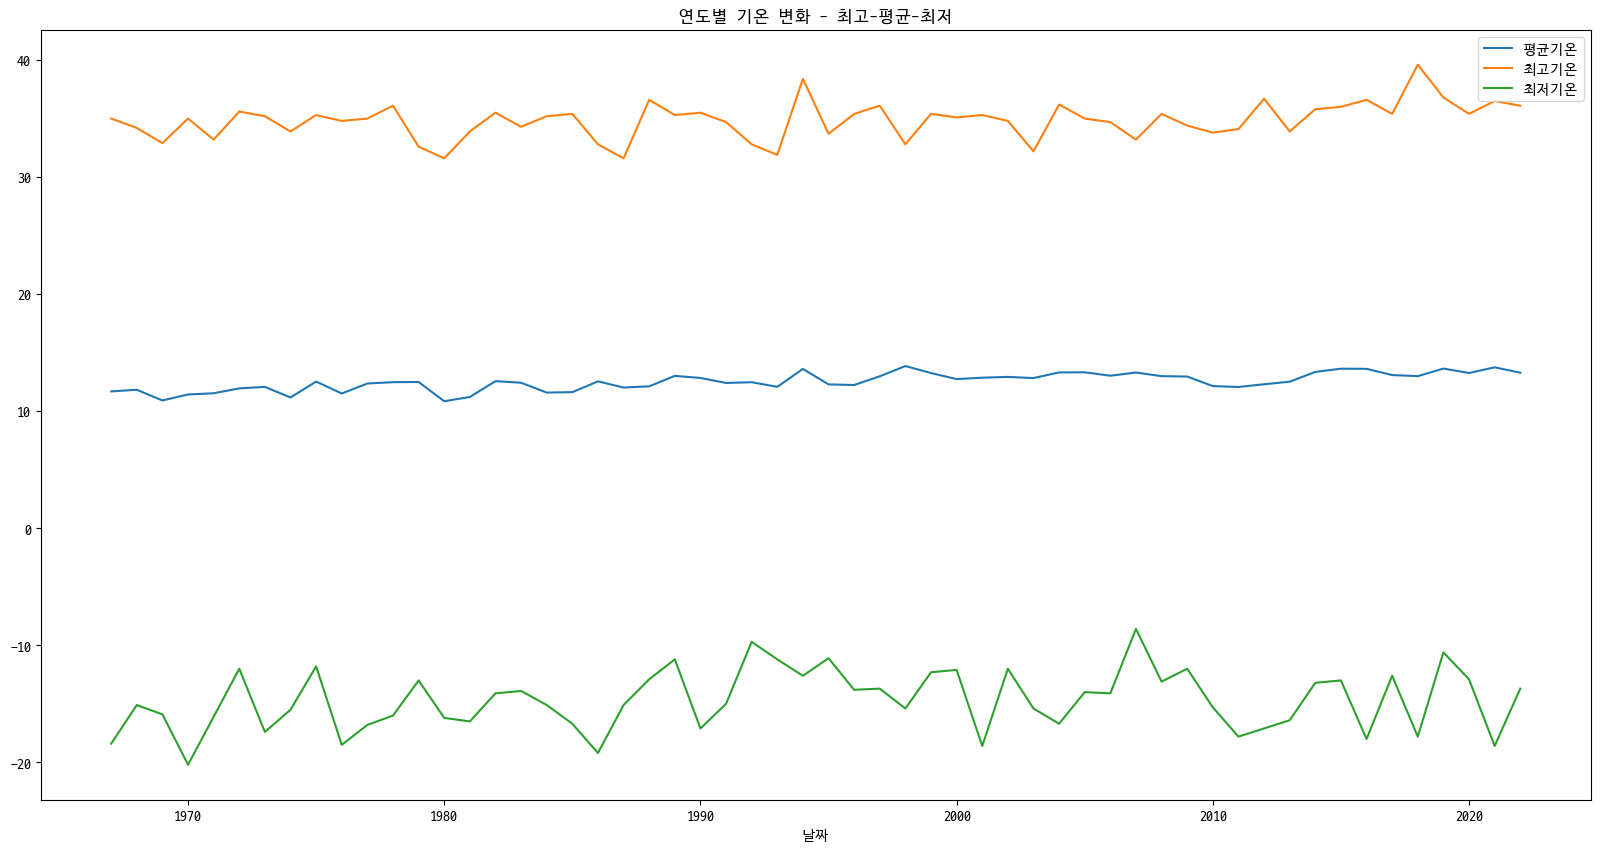

In [141]:
import matplotlib.pyplot as plt
yy_mean_max_min.plot(figsize=(20, 10))
plt.title('연도별 기온 변화 - 최고-평균-최저')
plt.show()

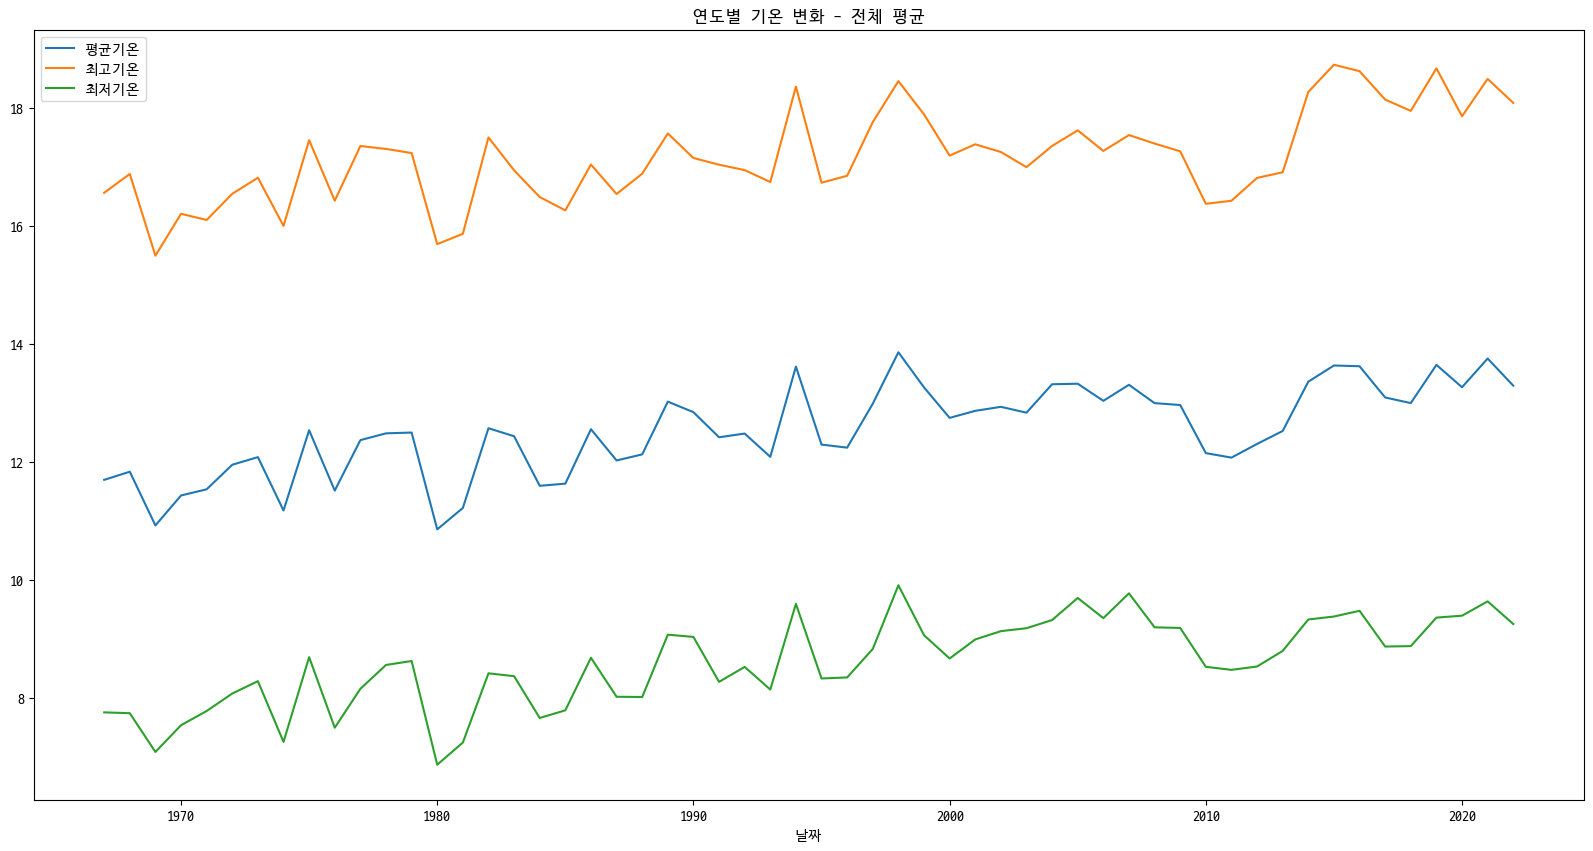

In [142]:
temp_col = ['평균기온', '최고기온', '최저기온']
yy_temp_mean_df = weather_df.groupby([weather_df.index.year])[temp_col].mean().drop(2023)
yy_temp_mean_df.plot(figsize=(20, 10))
plt.title('연도별 기온 변화 - 전체 평균')
plt.show()

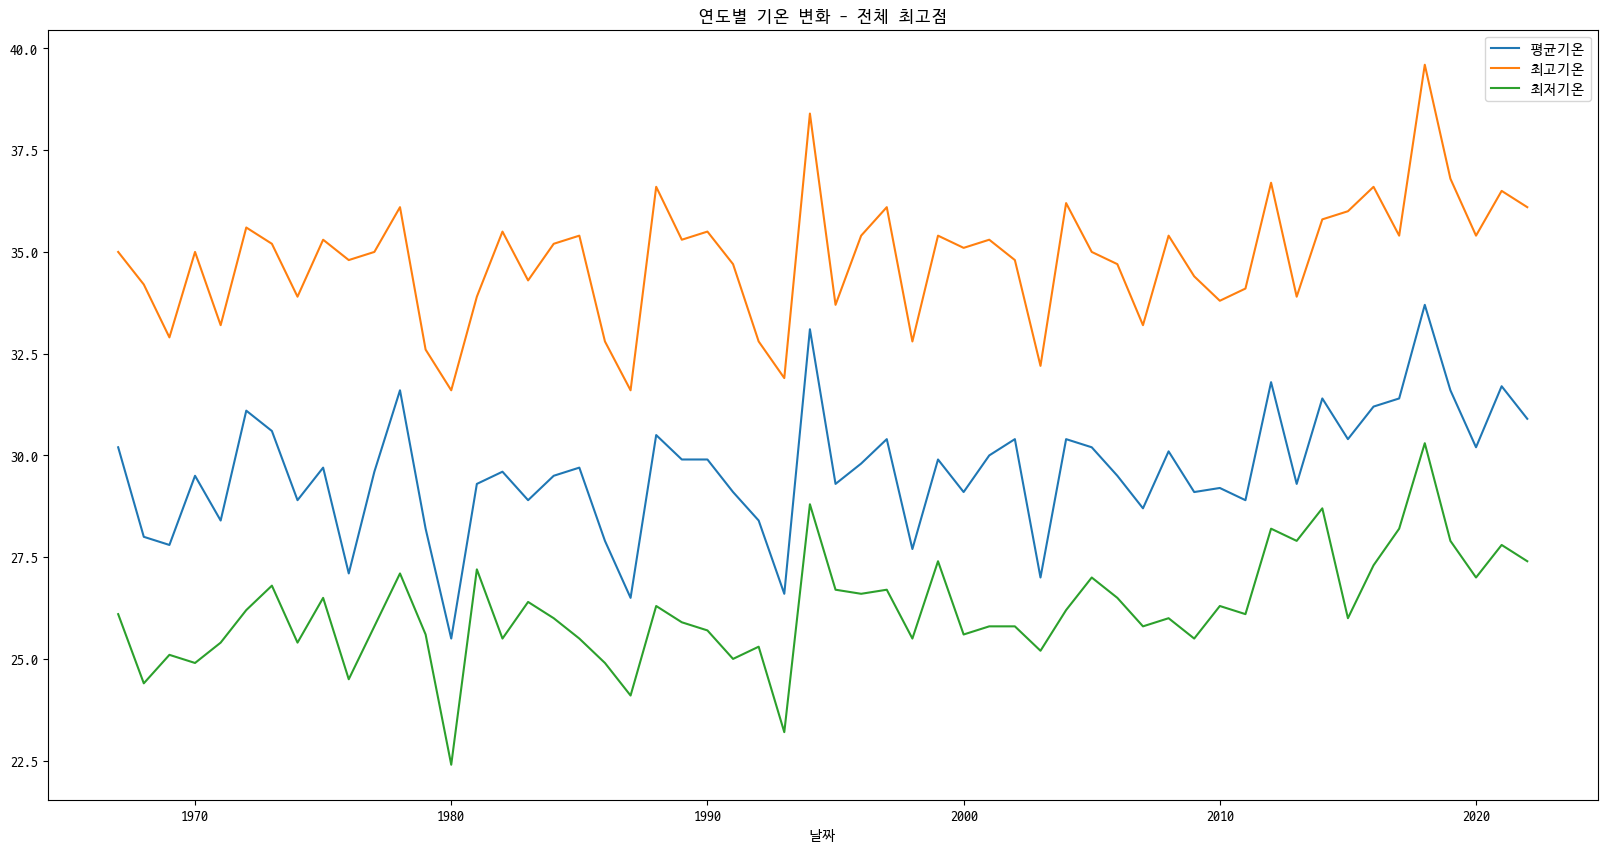

In [143]:
yy_temp_max_df = weather_df.groupby([weather_df.index.year])[temp_col].max().drop(2023)
yy_temp_max_df.plot(figsize=(20, 10))
plt.title('연도별 기온 변화 - 전체 최고점')
plt.show()

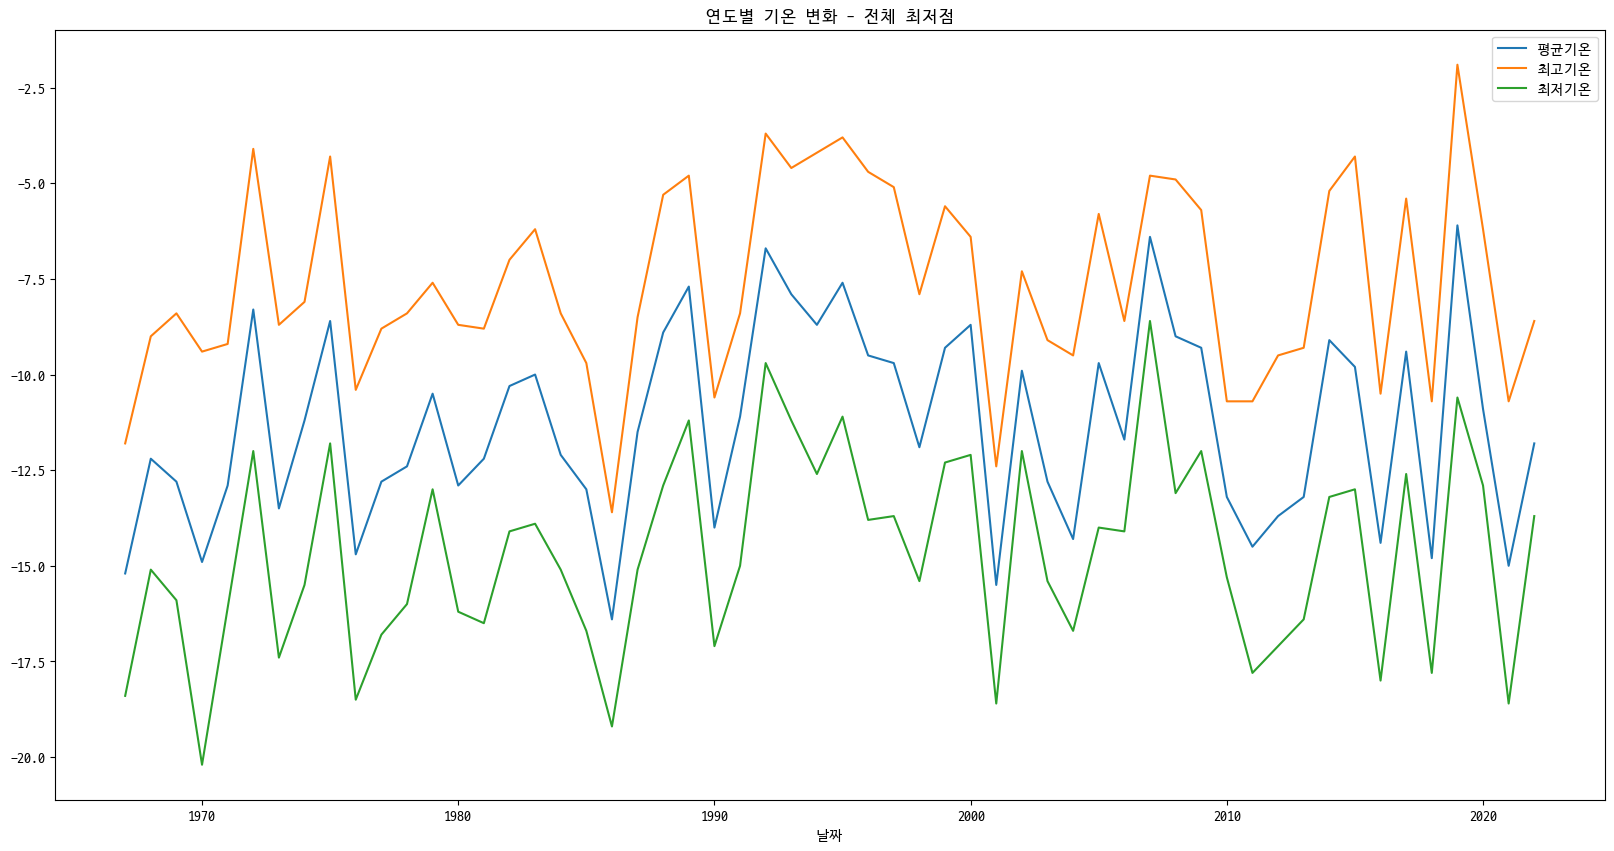

In [144]:
yy_temp_min_df = weather_df.groupby([weather_df.index.year])[temp_col].min().drop(2023)
yy_temp_min_df.plot(figsize=(20, 10))
plt.title('연도별 기온 변화 - 전체 최저점')
plt.show()

In [168]:
# 월별 강수량 평균
mm_rain_mean = weather_df.groupby([weather_df.index.month])['강수량(mm)'].mean()
mm_rain_mean

날짜
1      0.657602
2      0.965465
3      1.403801
4      2.594795
5      3.304596
6      4.470714
7     12.193750
8     10.725655
9      4.972679
10     1.672381
11     1.753036
12     0.735655
Name: 강수량(mm), dtype: float64

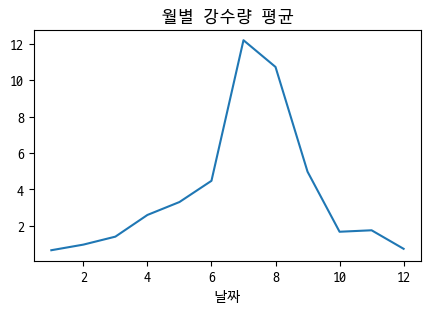

In [151]:
mm_rain_mean.plot(figsize=(5, 3))
plt.title('월별 강수량 평균')
plt.show()

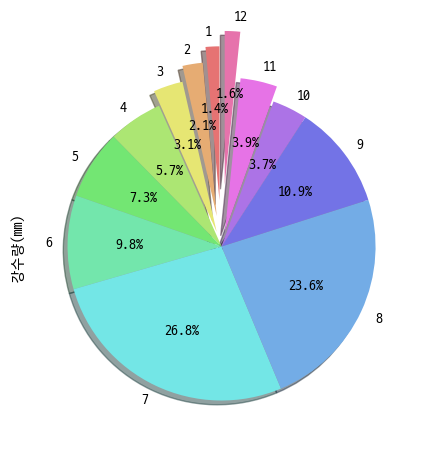

In [167]:
from test_color.color_list import rand_hex_list_hsv
colors = rand_hex_list_hsv(12, s=0.5, v=0.9)
# 파이차트 12, 1, 2, 3월은 튀어나오게
mm_rain_mean.plot(kind='pie',
                figsize=(5, 5),
                autopct='%1.1f%%',
                colors=colors,
                startangle=90,
                shadow=True,
                explode=(0.3, 0.2, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.4),
                )
plt.show()

In [172]:
# 월-년도별 강수량 평균의 합계
mm_yy_rain_mean = weather_df.groupby([weather_df.index.year, weather_df.index.month])['강수량(mm)'].mean()
mm_rain = mm_yy_rain_mean.groupby(level=1).sum()
mm_rain

날짜
1      37.483333
2      52.126970
3      80.016667
4     147.903333
5     188.910588
6     250.360000
7     682.850000
8     600.636667
9     278.470000
10     93.653333
11     98.170000
12     41.196667
Name: 강수량(mm), dtype: float64

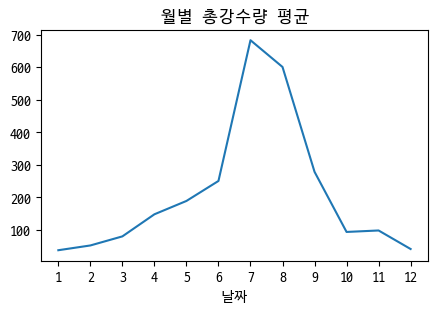

In [183]:
mm_rain.plot(figsize=(5, 3))
plt.title('월별 총강수량 평균')
plt.xticks(range(1, 13))
plt.show()


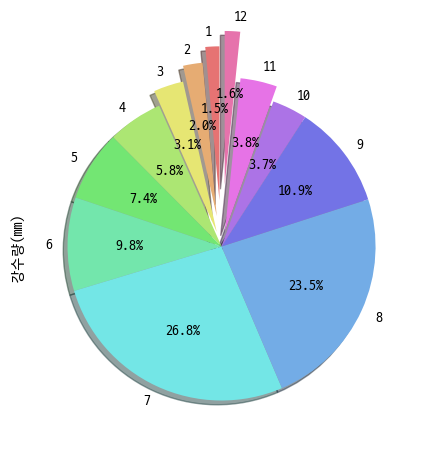

In [174]:
mm_rain.plot(kind='pie',
                figsize=(5, 5),
                autopct='%1.1f%%',
                colors=colors,
                startangle=90,
                shadow=True,
                explode=(0.3, 0.2, 0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.4),
                )
plt.show()

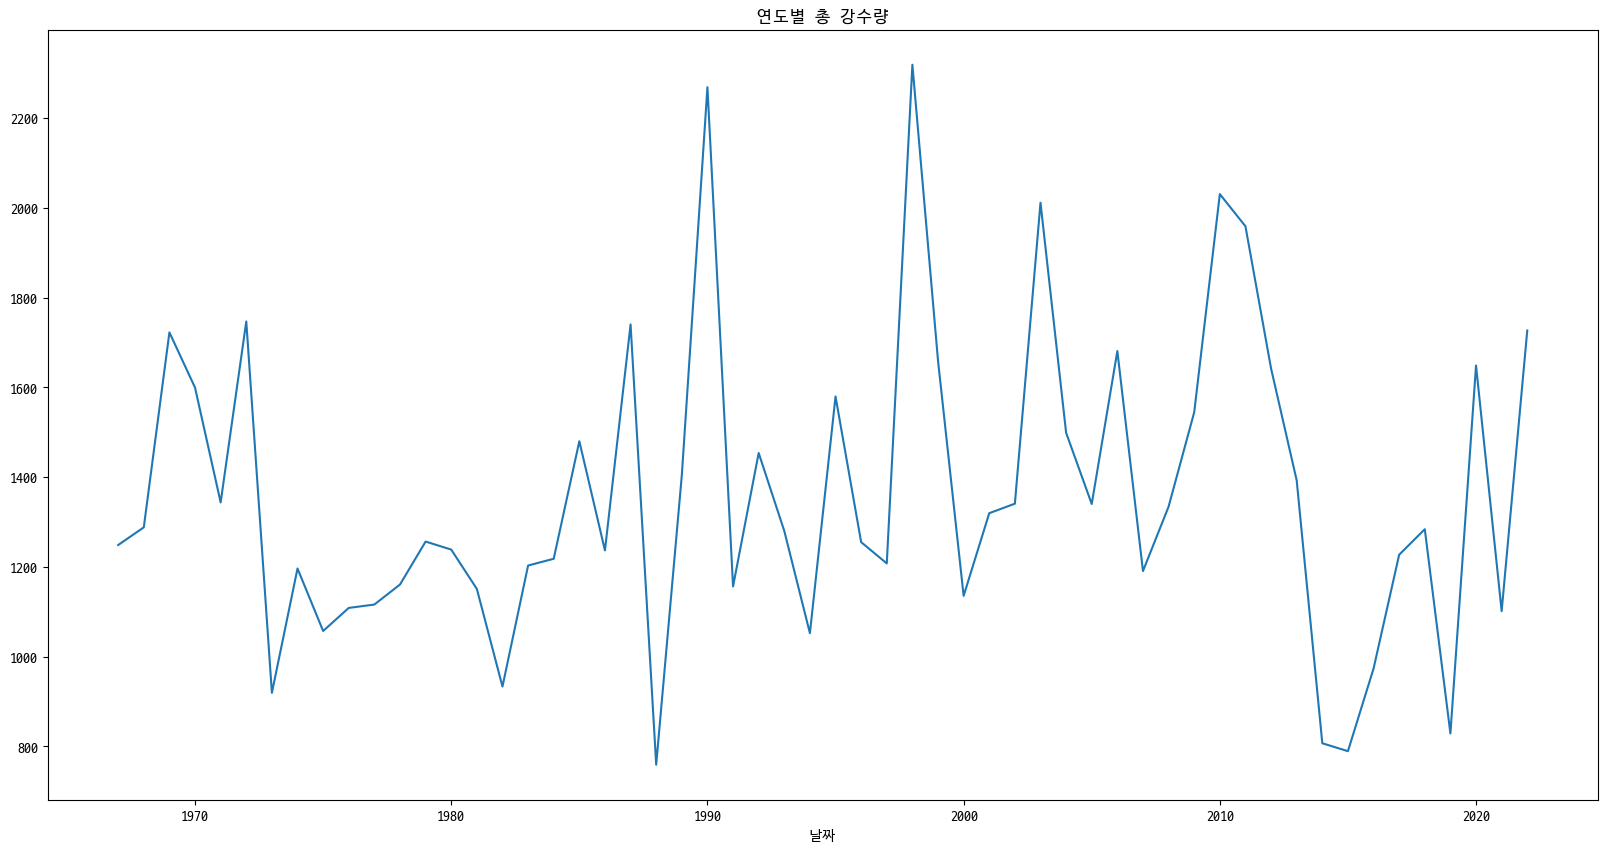

In [179]:
# 연도별 총 강수량
yy_rain_sum = weather_df.groupby(weather_df.index.year)['강수량(mm)'].sum().drop(2023)
yy_rain_sum.plot(figsize=(20, 10))
plt.title('연도별 총 강수량')
plt.show()

In [180]:
# 가장 강수량이 적은 연도
yy_rain_sum.idxmin()

1988